Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


Training InceptionResNetV2 + GRU Model...


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.4675 - loss: 1.0946 - val_accuracy: 0.5340 - val_loss: 0.8232
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.6651 - loss: 0.7862 - val_accuracy: 0.6408 - val_loss: 0.7448
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.6997 - loss: 0.6385 - val_accuracy: 0.7476 - val_loss: 0.6327
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7788 - loss: 0.5705 - val_accuracy: 0.7282 - val_loss: 0.6708
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7709 - loss: 0.5435 - val_accuracy: 0.7087 - val_loss: 0.6980
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7658 - loss: 0.5523 - val_accuracy: 0.7476 - val_loss: 0.6182
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7711 - loss: 0.4794 - val_accuracy: 0.6990 - val_loss: 0.7439
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8058 - loss: 0.4987 - val_accuracy: 0.7961 - val_loss:

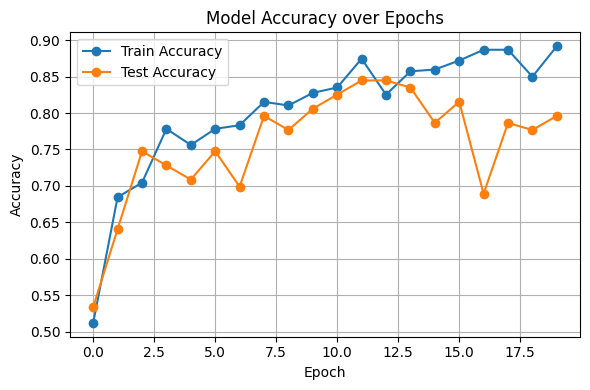

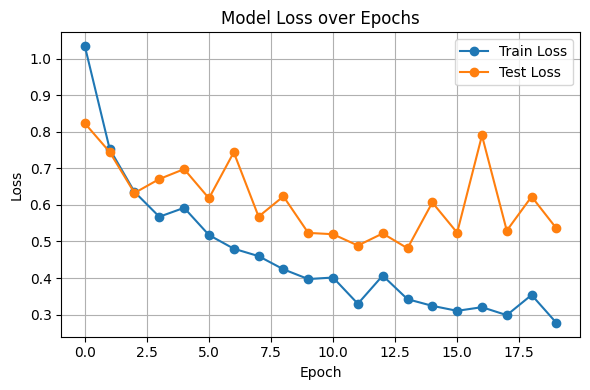

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input

# ---- Reproducibility ----
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 16
dropout_rate = 0.5
learning_rate = 0.001
target_size = (299, 299)  # InceptionResNetV2 input size
num_classes = 3
epochs = 20

# ---- Data Preprocessing ----
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ---- Build Model Function ----
def build_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Reshape((1, x.shape[-1]))(x)  # reshape for GRU input
    x = layers.GRU(256, return_sequences=False, dropout=dropout_rate, recurrent_dropout=0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base_model.input, outputs=output)

# ---- Create Model ----
inception_resnet_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
model = build_model(inception_resnet_base)

# ---- Compile the Model ----
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ---- Train the Model ----
print("\nTraining InceptionResNetV2 + GRU Model...")
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# ---- Save History ----
history_filename = 'inceptionResnetv2_GRU_new.pkl'
with open(history_filename, 'wb') as f:
    pickle.dump(history.history, f)
print(f"\nTraining history saved to {history_filename}")

# ---- Evaluate on Test Data ----
print("\nEvaluating on Test Data...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"InceptionResNetV2 + GRU Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"InceptionResNetV2 + GRU Test Loss: {test_loss:.4f}")

# ---- Evaluate on Train Data ----
print("\nEvaluating on Training Data...")
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# ---- Evaluate on Validation Data ----
print("\nEvaluating on Validation Data...")
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# ---- Plot Accuracy ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Optional: Save Model ----
# model.save('inceptionResnetv2_GRU_model.keras')
# print("Model saved as inceptionResnetv2_GRU_model.keras")


In [6]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

94/94 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.80      0.68      0.73       500
               Nor       0.97      0.99      0.98       500
Squamous_carcinoma       0.75      0.85      0.79       500

          accuracy                           0.84      1500
         macro avg       0.84      0.84      0.84      1500
      weighted avg       0.84      0.84      0.84      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.75      0.85      0.80        39
               Nor       0.86      0.77      0.81        31
Squamous_carcinoma       0.81      0.76      0.78        33

          accuracy                           0.80       103
         macro avg       0.80      0.79      0.80       103
      weighted avg       0.80      0.80      0.80       103

Validation Accuracy: 0.837333

Class Labels: ['Adenocarcinoma', 'Nor', 'Squamous_carcinoma']
94/94 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


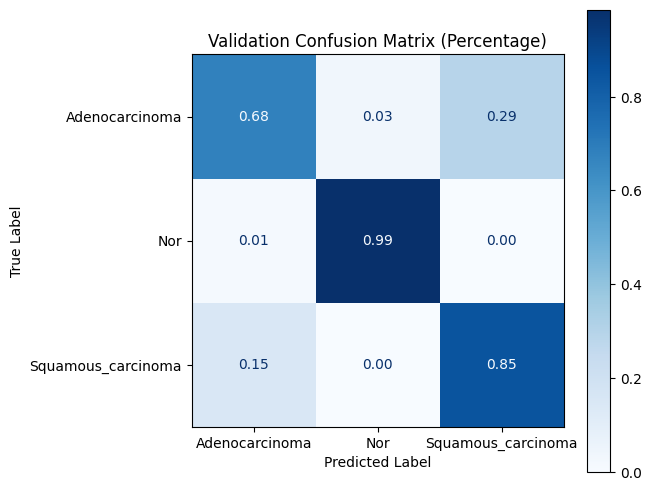

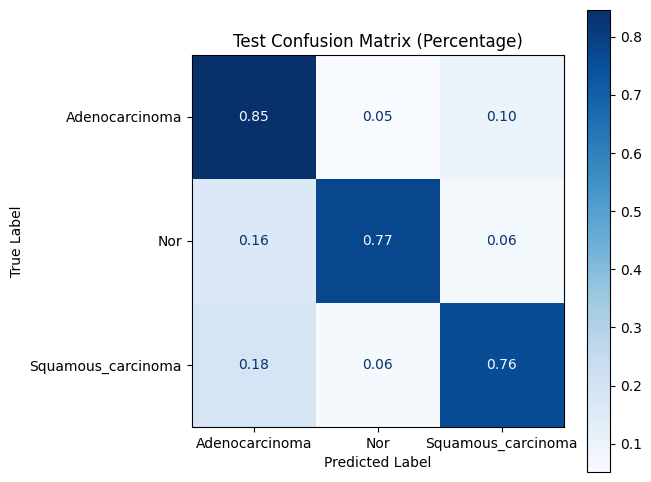

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Get Class Labels ---
class_names = list(val_generator.class_indices.keys())
print("Class Labels:", class_names)

# --- Predict on Validation and Test Sets ---
val_preds = model.predict(val_generator)
test_preds = model.predict(test_generator)

# --- Convert probabilities to class labels ---
val_pred_classes = np.argmax(val_preds, axis=1)
test_pred_classes = np.argmax(test_preds, axis=1)

# --- Get true labels ---
val_true_classes = val_generator.classes
test_true_classes = test_generator.classes

# --- Confusion Matrices ---
val_cm = confusion_matrix(val_true_classes, val_pred_classes)
test_cm = confusion_matrix(test_true_classes, test_pred_classes)

# --- Normalize Confusion Matrices to Percentages ---
val_cm_percent = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis] 
test_cm_percent = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis] 

# --- Plot Function ---
def plot_confusion_matrix(cm, classes, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax, colorbar=True)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Plot Confusion Matrices ---
plot_confusion_matrix(val_cm_percent, class_names, "Validation Confusion Matrix (Percentage)")
plot_confusion_matrix(test_cm_percent, class_names, "Test Confusion Matrix (Percentage)")


In [12]:
model.save("InceptionresnetV2_RS.keras")

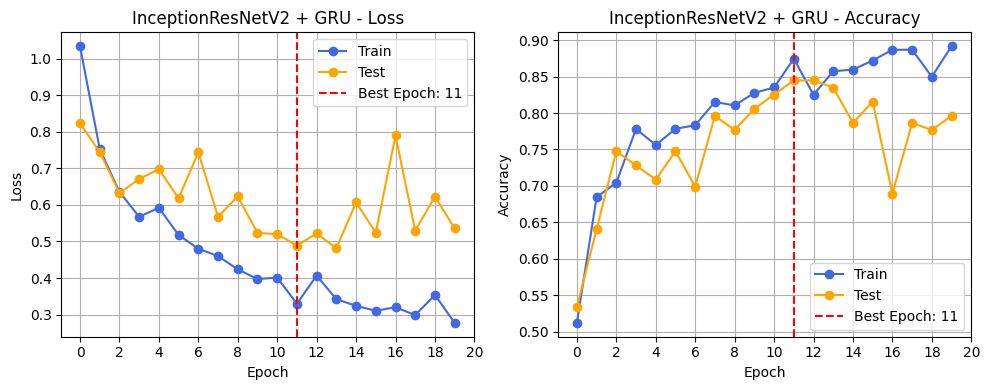

In [19]:
import pickle
import matplotlib.pyplot as plt

# 🔹 Load InceptionResNetV2 + GRU model history
history_path = r'C:\Users\Milanjyoti\Desktop\lp\inceptionResnetv2_GRU_new1.pkl'

with open(history_path, 'rb') as f:
    inception_resnet_gru_history = pickle.load(f)

# 🔹 Function to plot Loss and Accuracy with subplots
def plot_inceptionresnet_gru(history, best_epoch=None, max_epochs=20):
    plt.figure(figsize=(10, 4))

    x_values = list(range(max_epochs))
    x_ticks = list(range(0, max_epochs + 1, 2))  # 0, 2, 4, ...

    # 1️⃣ Loss subplot
    plt.subplot(1, 2, 1)
    train_loss = history['loss'][:max_epochs]
    val_loss = history['val_loss'][:max_epochs]

    plt.plot(x_values, train_loss, label='Train', color='royalblue', marker='o')
    plt.plot(x_values, val_loss, label='Test', color='orange', marker='o')

    if best_epoch is not None:
        plt.axvline(x=best_epoch, linestyle='--', color='red', label=f'Best Epoch: {best_epoch}')

    plt.title('InceptionResNetV2 + GRU - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(x_ticks)
    plt.legend()
    plt.grid(True)

    # 2️⃣ Accuracy subplot
    plt.subplot(1, 2, 2)
    train_acc = history['accuracy'][:max_epochs]
    val_acc = history['val_accuracy'][:max_epochs]

    plt.plot(x_values, train_acc, label='Train', color='royalblue', marker='o')
    plt.plot(x_values, val_acc, label='Test', color='orange', marker='o')

    if best_epoch is not None:
        plt.axvline(x=best_epoch, linestyle='--', color='red', label=f'Best Epoch: {best_epoch}')

    plt.title('InceptionResNetV2 + GRU - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(x_ticks)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 🔹 Set the best epoch (optional, zero-indexed)
best_epoch = 11

# 🔹 Plot
plot_inceptionresnet_gru(inception_resnet_gru_history, best_epoch=best_epoch, max_epochs=20)
